### __Project: Credit Card Fraud Prediction Using K-Nearest Neighbours__
### Author: Clara Lima Pereira
### GitHub: https://github.com/claralim-a


In [2]:
import pandas as pd
import numpy as np 
import time
from scipy.stats import skew, norm

# kaggle
import kaggle

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# sklearn
from sklearn.preprocessing import RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, roc_curve,roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

In [3]:
# Imports database from Kaggle 
kaggle.api.authenticate()
kaggle.api.dataset_download_files('mlg-ulb/creditcardfraud', path ='.', unzip = True)
df = pd.read_csv('creditcard.csv')
df.describe()

# Sets a random seed for the randomization
seed = 1


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud


## 1. Preprocessing the Data

Variables
- Time: Number of seconds elapsed between this transaction and the first transaction in the dataset;
- V1 - V28: Anonymous features created using Principal Component Analysis (PCA). These are transformed versions of the original features (like merchant ID, location, etc.) to protect confidentiality;
- Amount: The transaction amount in Euros;
- Class: Target variable  — 0 = Not Fraud, 1 = Fraud.

Not Fraudulent: 99.83
Fraudulent: 0.17

Using the original dataset can cause: 
 1. Overfitting; 
 2. Wrong Correlations


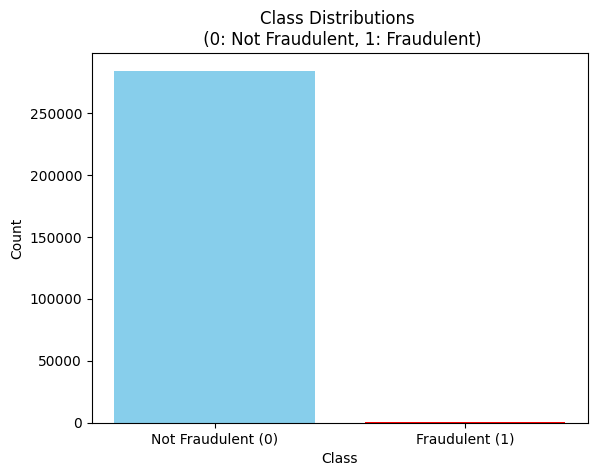

In [4]:
# Calculate how many entries belong to each class (0: Not Fraudulent, 1: Fraudulent)
class_counts = df['Class'].value_counts()
total = len(df)

# Print percentage distribution of each class
print("Not Fraudulent:", round(class_counts[0] / total * 100, 2))
print("Fraudulent:", round(class_counts[1] / total * 100, 2))

# Note on class imbalance issues
print("\nUsing the original dataset can cause: \n 1. Overfitting; \n 2. Wrong Correlations")

# Plotting the class distribution
classes = [0, 1]
counts = [class_counts[0], class_counts[1]]
colors = ['skyblue', 'red']

plt.bar(classes, counts, color=colors)
plt.xticks([0, 1], ['Not Fraudulent (0)', 'Fraudulent (1)'])
plt.title('Class Distributions \n (0: Not Fraudulent, 1: Fraudulent)', fontsize=12)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


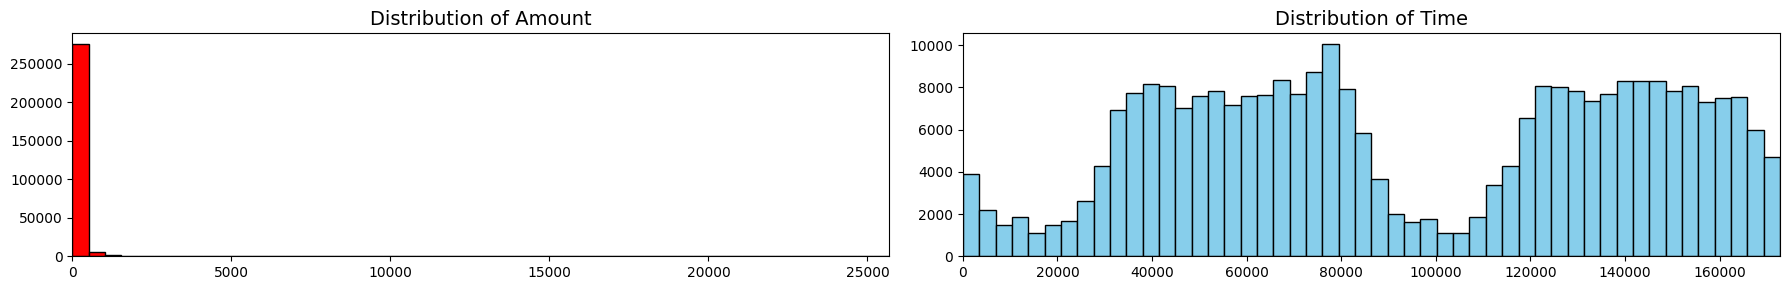

In [5]:
# Extract 'Amount' and 'Time' values from the dataset
amount_val = df['Amount'].values
time_val = df['Time'].values

# Create a figure with 2 subplots side by side
fig, axes =plt.subplots(1, 2, figsize = (18,3))

# Amount
axes[0].hist(amount_val, bins = 50, color = 'red', edgecolor='black')
axes[0].set_title('Distribution of Amount', fontsize=14)
axes[0].set_xlim([min(amount_val), max(amount_val)])

# Time
axes[1].hist(time_val, bins = 50, color = 'skyblue', edgecolor='black')
axes[1].set_title('Distribution of Time', fontsize=14)
axes[1].set_xlim([min(time_val), max(time_val)])

plt.tight_layout()
plt.show()


Scaling Time and Amount

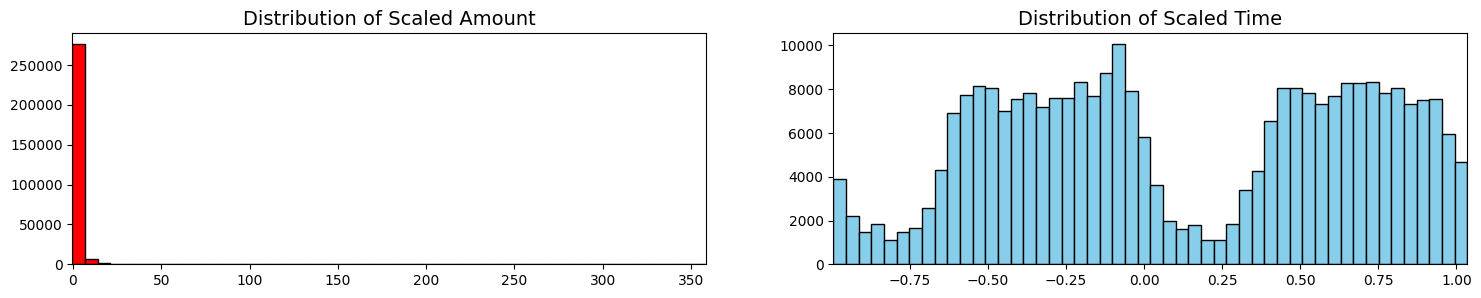

In [6]:
# Initialize RobustScaler, suitable for features with outliers
robust_scaler = RobustScaler()

# Scale 'Amount' and add as a new column
df['scaled_amount'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

# Scale 'Time' and add as a new column
df['scaled_time'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Extract scaled values for plotting
scaled_amount_value = df['scaled_amount'].values
scaled_time_value = df['scaled_time'].values

# Dropping original, unscaled columns
df.drop(['Time', 'Amount'], axis = 1, inplace = True) 

# Plot histograms of scaled features side by side
fig, axes = plt.subplots(1,2, figsize=(18,3))

axes[0].hist(scaled_amount_value, bins = 50, color='r', edgecolor='black')
axes[0].set_title('Distribution of Scaled Amount', fontsize=14)
axes[0].set_xlim([min(scaled_amount_value), max(scaled_amount_value)])

axes[1].hist(scaled_time_value, bins = 50, color='skyblue', edgecolor='black')
axes[1].set_title('Distribution of Scaled Time', fontsize=14)
axes[1].set_xlim([min(scaled_time_value), max(scaled_time_value)])

plt.show()


Checking the distribution of each variable

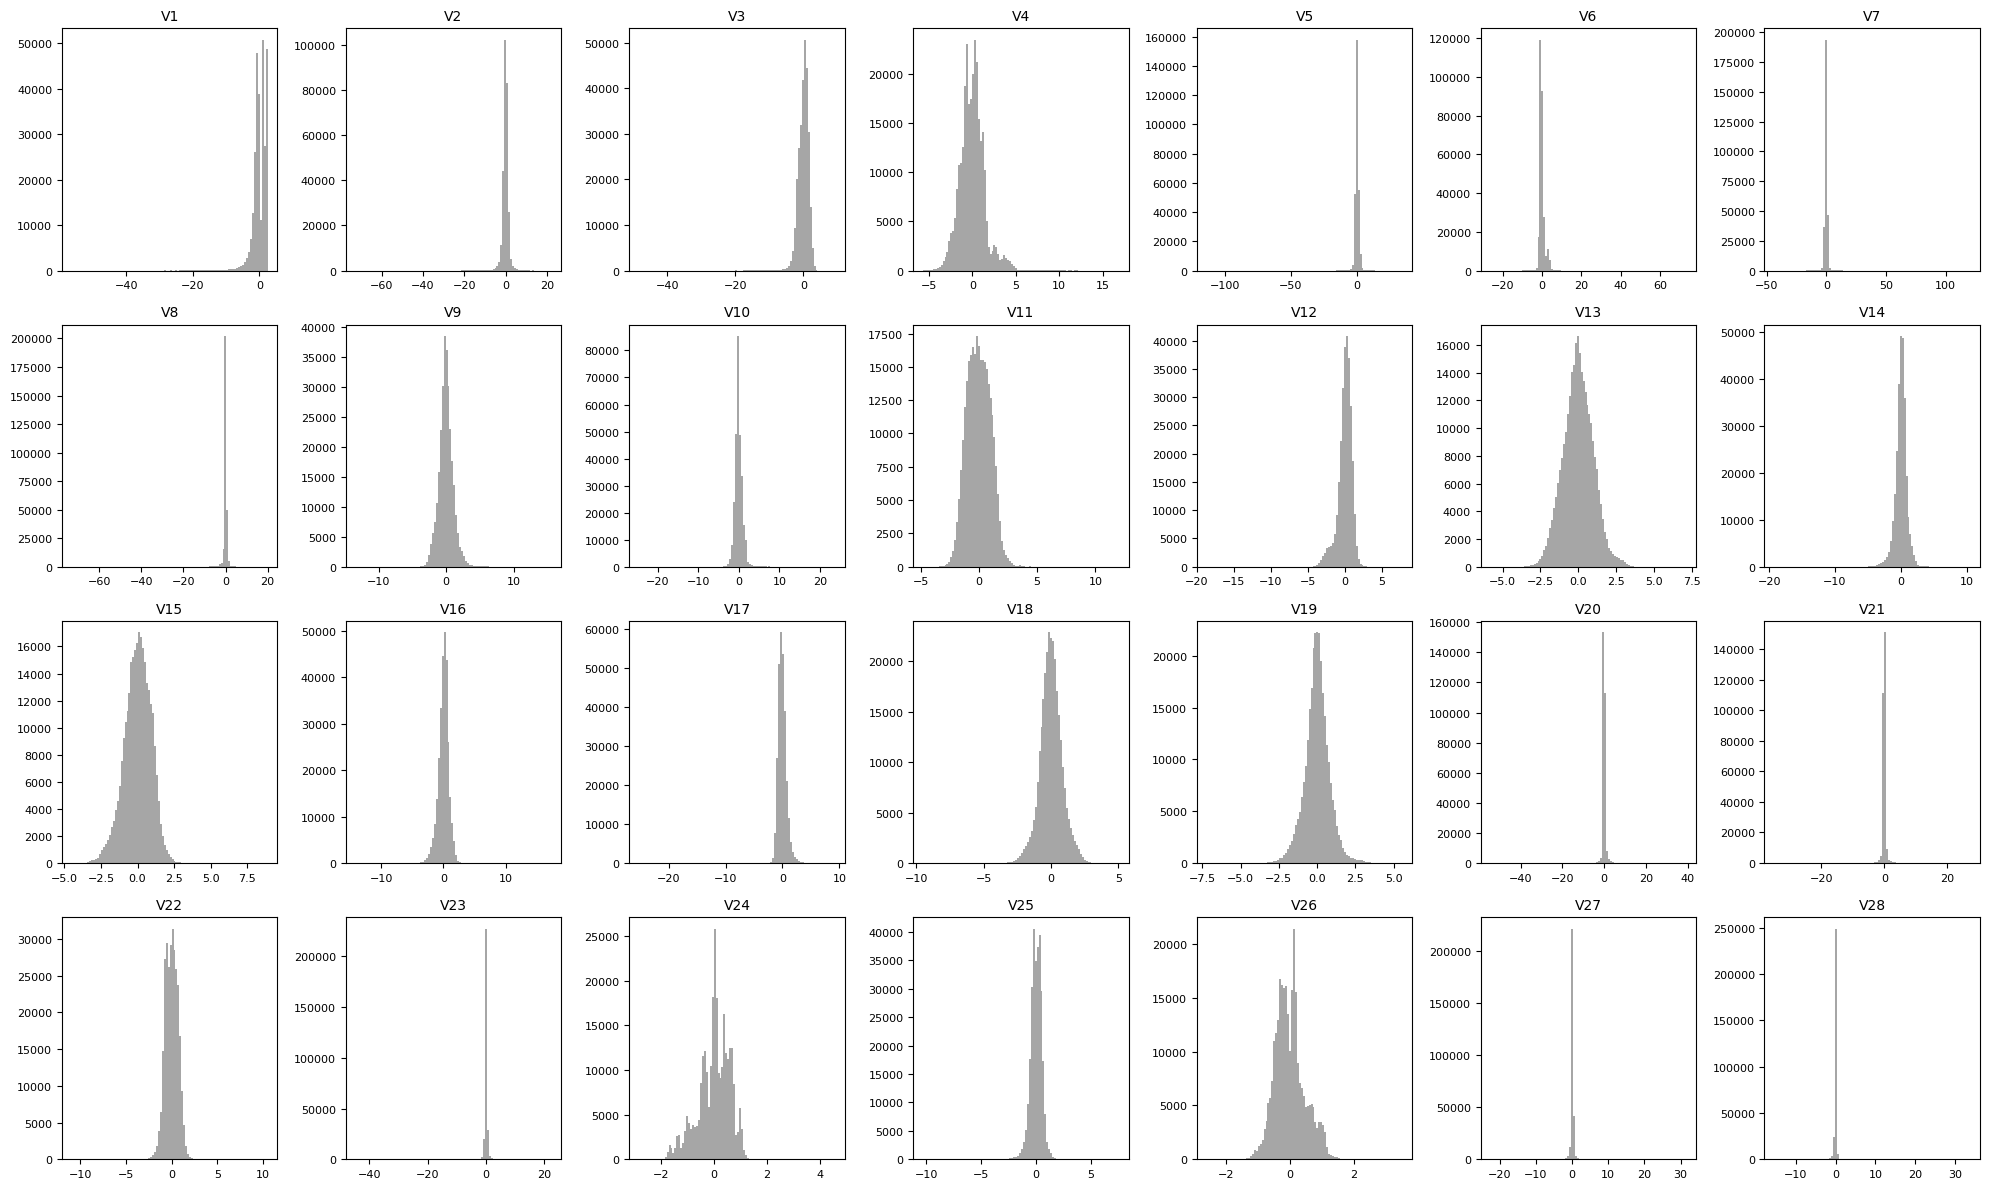

In [7]:
# Create a 4x7 grid of subplots for plotting distributions of variables V1 to V28
fig,axes = plt.subplots(4, 7, figsize=(20,12))

# Flatten the 2D axes array to a 1D list for easier iteration
axes = axes.flatten() # Matrix -> Vector

variables = {}

# Loop through variables V1 to V28
for i in range(28):
    var = f"V{i+1}"
    variables[var] = df[var].values
    
    # Plot histogram of the variable in the corresponding subplot
    axes[i].hist(variables[var], bins=100, color='grey', alpha=0.7)
    
    # Set title and adjust font sizes for readability
    axes[i].set_title(var, fontsize=10)
    axes[i].tick_params(axis='x', labelsize=8)
    axes[i].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()



Fixing skewness

Highly skewed columns: {'V1': np.float64(-3.280650024359956), 'V2': np.float64(-4.624841215356954), 'V8': np.float64(-8.521899311980174), 'V17': np.float64(-3.844894223735797), 'V21': np.float64(3.5929722697554753), 'V23': np.float64(-5.875109397316075), 'V28': np.float64(11.19203224646587), 'Class': np.float64(23.99745292182408), 'scaled_amount': np.float64(16.977635036633128)}


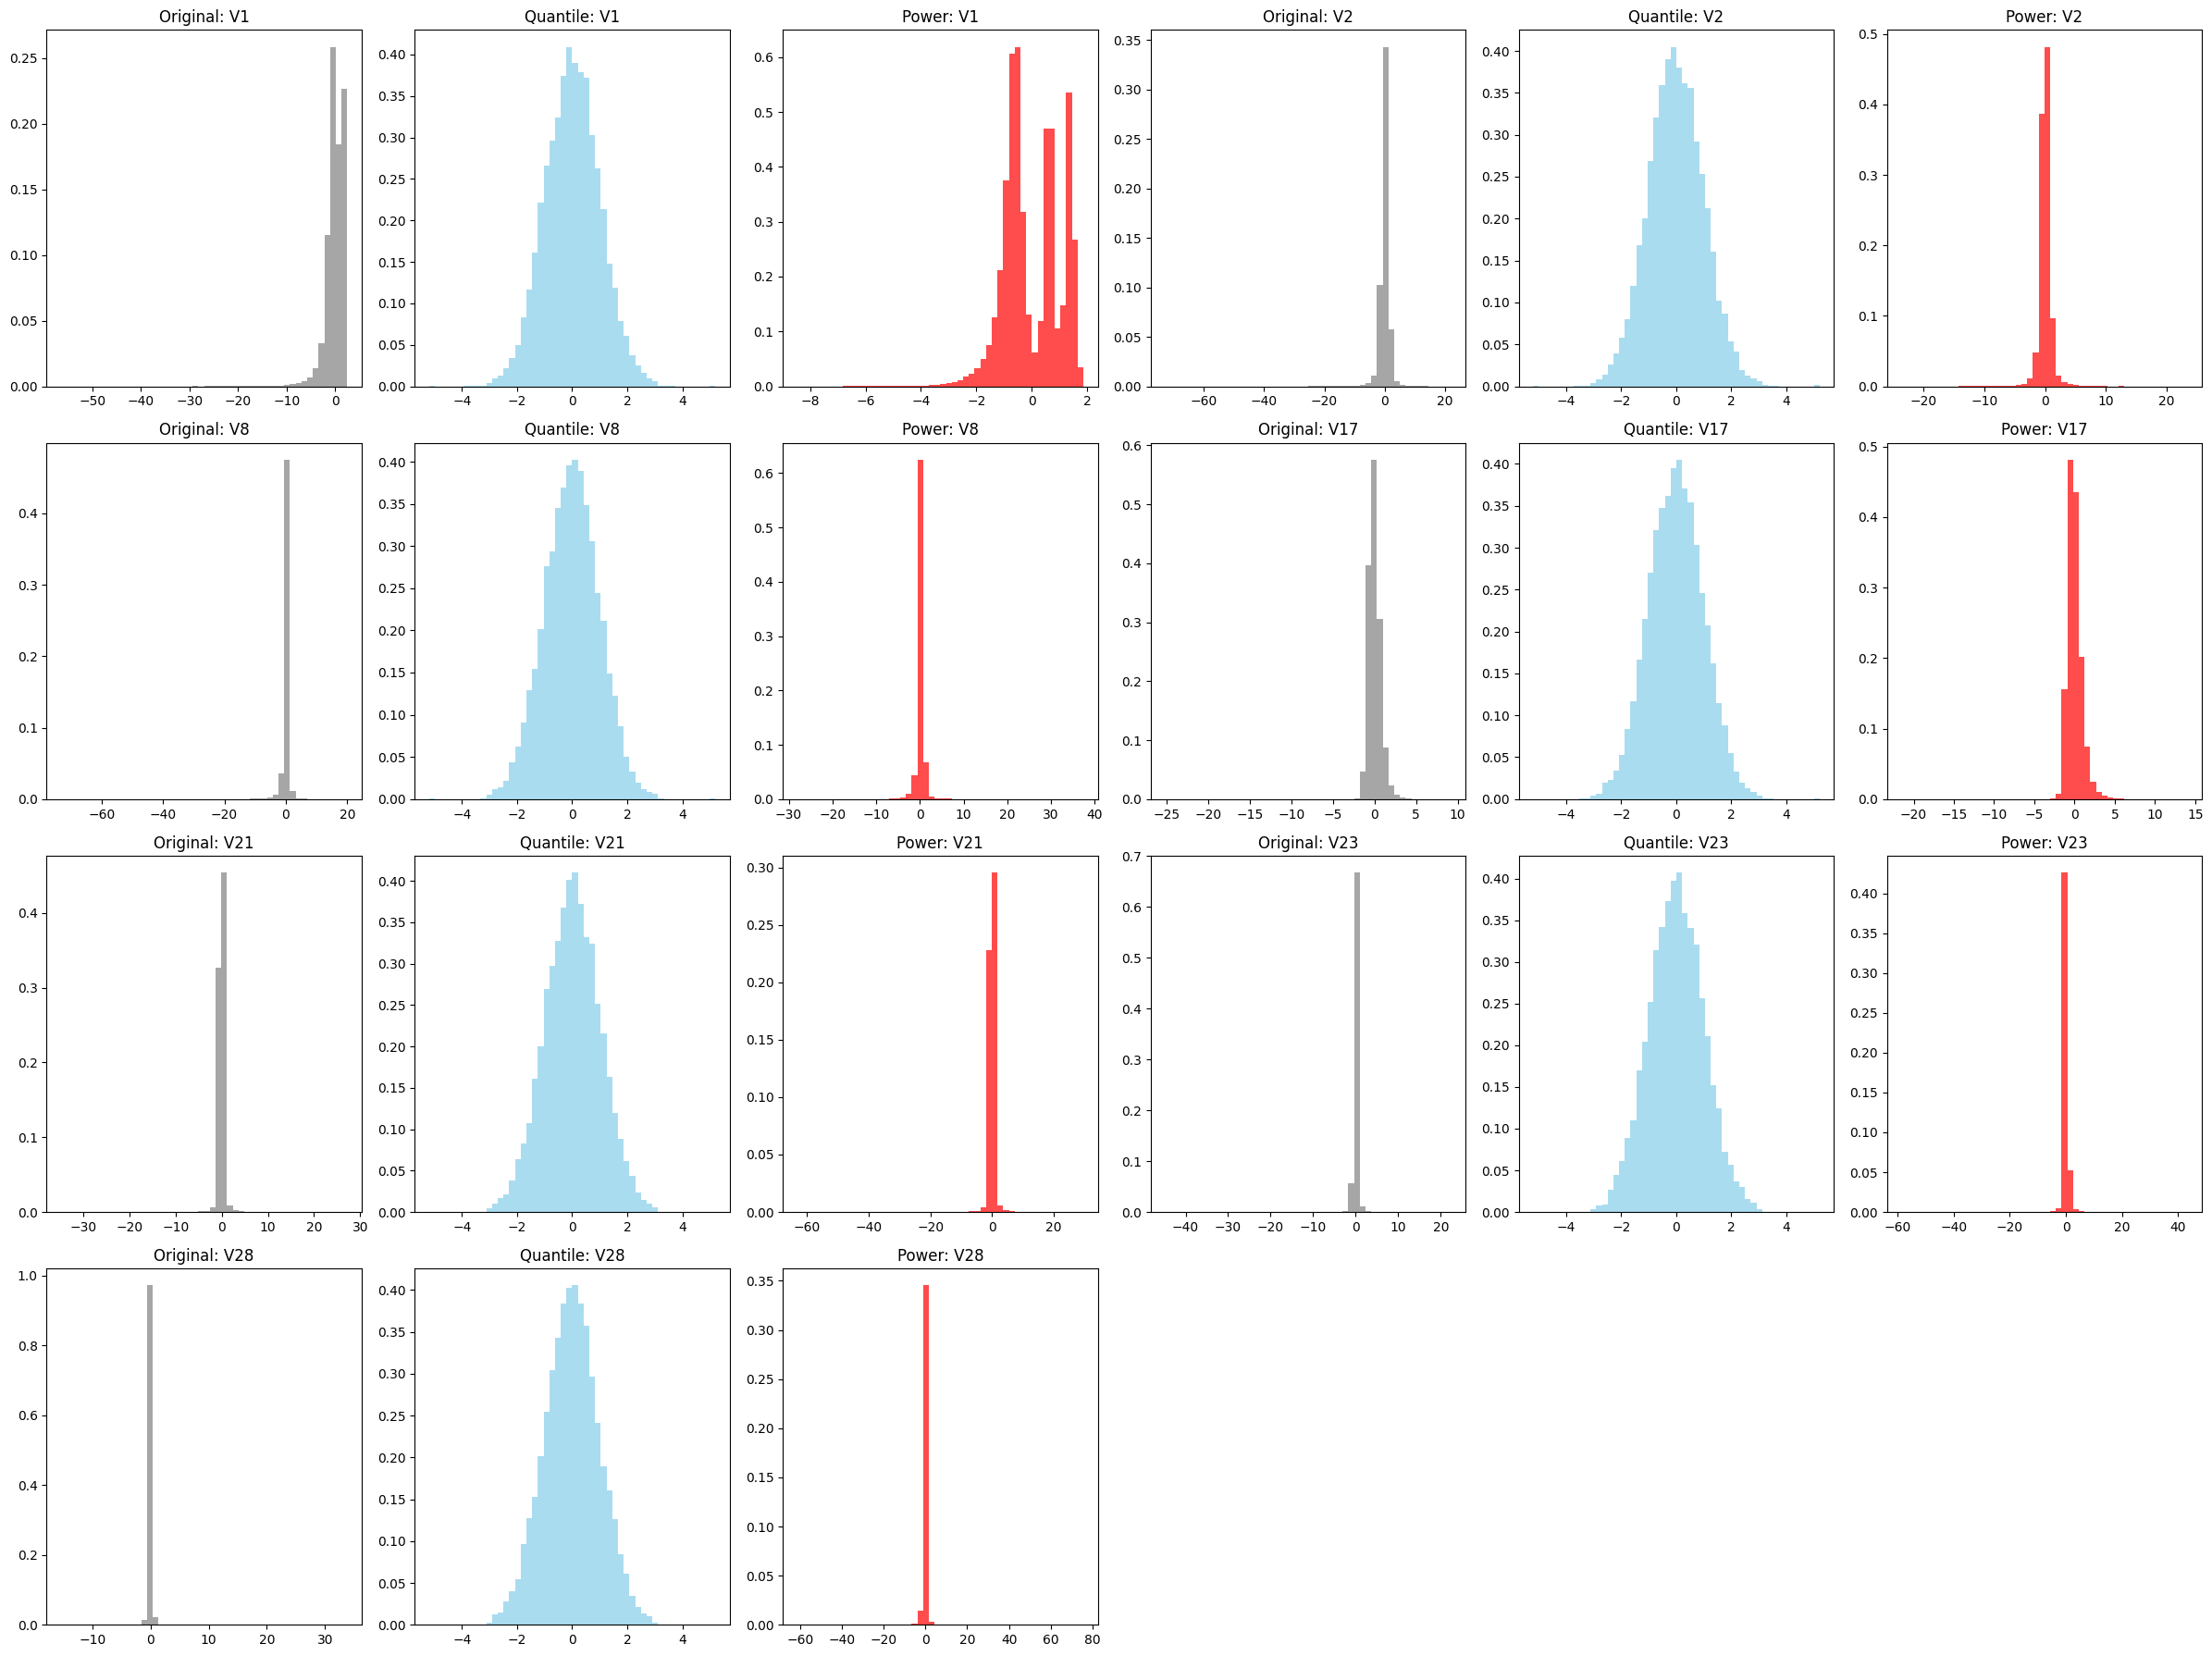

In [8]:
# Function to identify numeric columns with high skewness
def get_skewed_columns(df, threshold=3.0):
    """
    Returns a dictionary of columns with absolute skewness above the threshold.
    """    
    skew_dict = {
        col: skew(df[col])
        for col in df.select_dtypes(include=['float64', 'int64']).columns
    }
    # Filter columns where skewness magnitude is above the threshold

    return {col: val for col, val in skew_dict.items() if abs(val) > threshold}

# Function to visualize original and transformed distributions for columns
def test_transformers(df, columns):
    """
    For each column, plots histograms of the original data,
    QuantileTransformer output, and PowerTransformer output.
    """    
    pt = PowerTransformer()
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=0)

    fig = plt.figure(figsize=(24, 18))
    rows, cols = 4, 6

    for idx, col in enumerate(columns):
        array = df[col].values.reshape(-1, 1)
        # Apply transformations

        qt_transf = qt.fit_transform(array)
        pt_transf = pt.fit_transform(array)

        plot_idx = idx * 3
        
        # Original distribution
        plt.subplot(rows, cols, plot_idx + 1)
        plt.hist(array, bins=50, density=True, alpha=0.7, color='grey')
        plt.title(f"Original: {col}")

        # Quantile transformation distribution
        plt.subplot(rows, cols, plot_idx + 2)
        plt.hist(qt_transf, bins=50, density=True, alpha=0.7, color='skyblue')
        plt.title(f"Quantile: {col}")

        # Power transformation distribution
        plt.subplot(rows, cols, plot_idx + 3)
        plt.hist(pt_transf, bins=50, density=True, alpha=0.7, color='red')
        plt.title(f"Power: {col}")

    plt.tight_layout()
    plt.show()

# Function to apply QuantileTransformer on given columns and overwrite them
def apply_quantile_transform(df, columns):
    """
    Applies QuantileTransformer to specified columns and updates the dataframe.
    """    
    qt = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=seed)
    for col in columns:
        array = df[col].values.reshape(-1, 1)
        df[col] = qt.fit_transform(array)

# Find highly skewed columns (by default skewness > 3)
skewed_cols = get_skewed_columns(df)
print("Highly skewed columns:", skewed_cols)

# Filter skewed columns that start with "V" (domain-specific choice)
v_skewed_cols = [col for col in skewed_cols if col.startswith("V")]

# Visualize the original and transformed distributions for selected skewed variables
test_transformers(df, v_skewed_cols)

# Apply quantile transformation to the skewed 'V' variables to reduce skewness
apply_quantile_transform(df, v_skewed_cols)


Subsampling

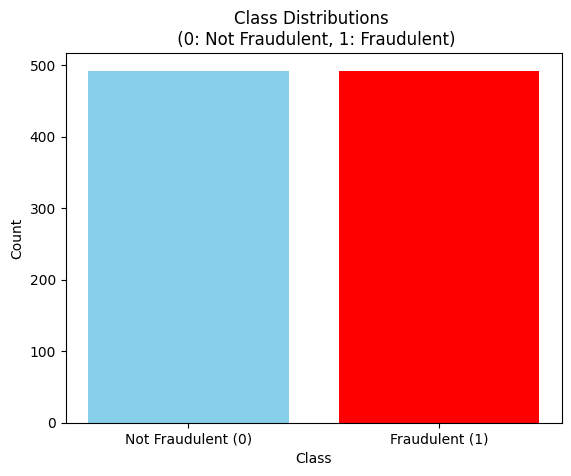

In [9]:
# Shuffle the entire dataframe randomly 
df = df.sample(frac = 1, random_state=seed)

# Separate non-fraudulent and fraudulent cases
not_fraud_df = df[df['Class'] == 0][:492]
fraud_df = df[df['Class'] == 1] # len 492

# Combine the two subsets to create a balanced dataset
df_concat = pd.concat([not_fraud_df, fraud_df])

# Shuffle the balanced dataset with a fixed seed for reproducibility
df_sample = df_concat.sample(frac = 1, random_state=seed)

# Show the first few rows to check the new balanced dataset
df_sample.head()

# Plot class distribution of the balanced dataset
class_counts = df_sample['Class'].value_counts()
classes = [0, 1]
counts = [class_counts[0], class_counts[1]]
colors = ['skyblue', 'red']

plt.bar(classes, counts, color=colors)
plt.xticks([0, 1], ['Not Fraudulent (0)', 'Fraudulent (1)'])
plt.title('Class Distributions \n (0: Not Fraudulent, 1: Fraudulent)', fontsize=12)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Correlation Matrices

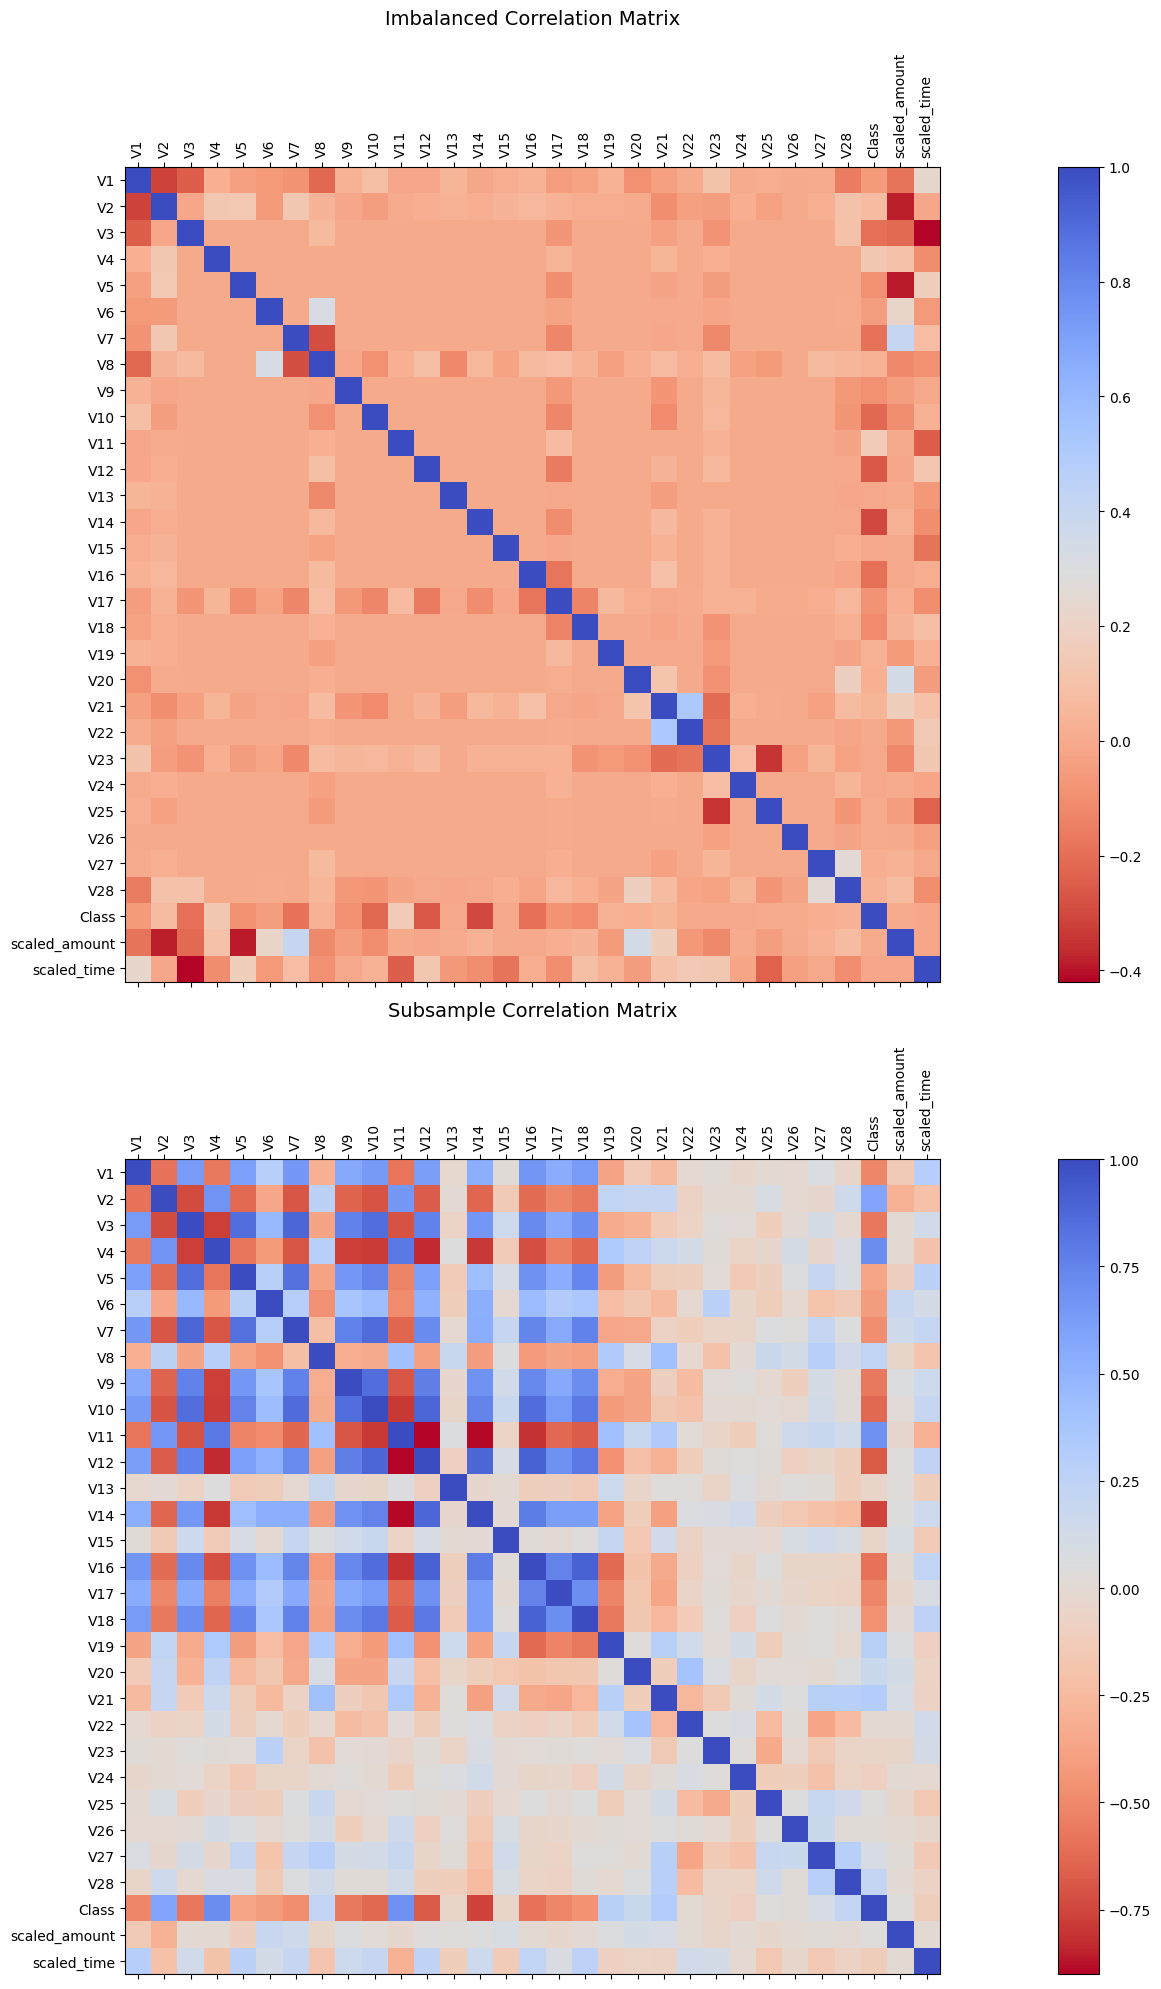

In [10]:
# Compute correlation matrices for original and balanced datasets
corr = df.corr()
sub_sample_corr = df_sample.corr()

# Create two vertical subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 20))

# Helper function to plot a correlation heatmap using matplotlib
def plot_corr_heatmap(corr_matrix, ax, title):
    """
    Plots a correlation heatmap on the given axes.
    """    
    # Show the correlation matrix as an image with color mapping
    cax = ax.matshow(corr_matrix, cmap='coolwarm_r')
    
    # Add a colorbar to show correlation scale
    fig.colorbar(cax, ax=ax)
    
    # Title for the plot
    ax.set_title(title, fontsize=14, pad=20)

    # Label ticks with column names
    ticks = np.arange(0, len(corr_matrix.columns), 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(corr_matrix.columns, rotation=90)
    ax.set_yticklabels(corr_matrix.columns)

# Plot correlation heatmaps
plot_corr_heatmap(corr, ax1, "Imbalanced Correlation Matrix")
plot_corr_heatmap(sub_sample_corr, ax2, "Subsample Correlation Matrix")

plt.tight_layout()
plt.show()




Examining negative/positive correlations with the target variable class

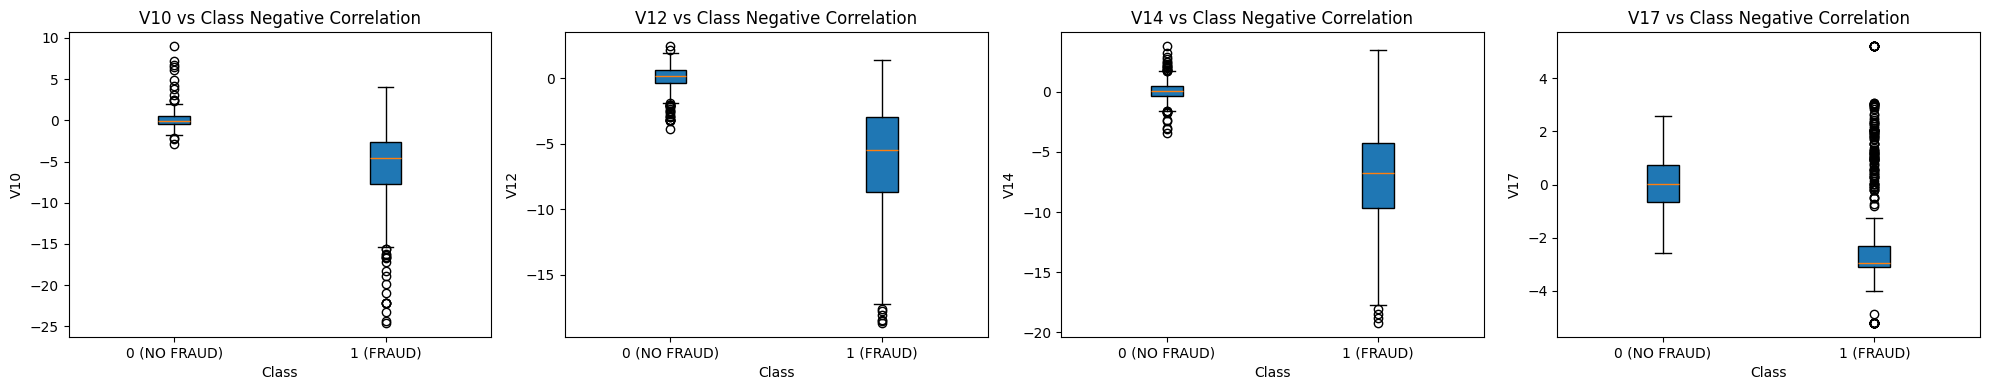

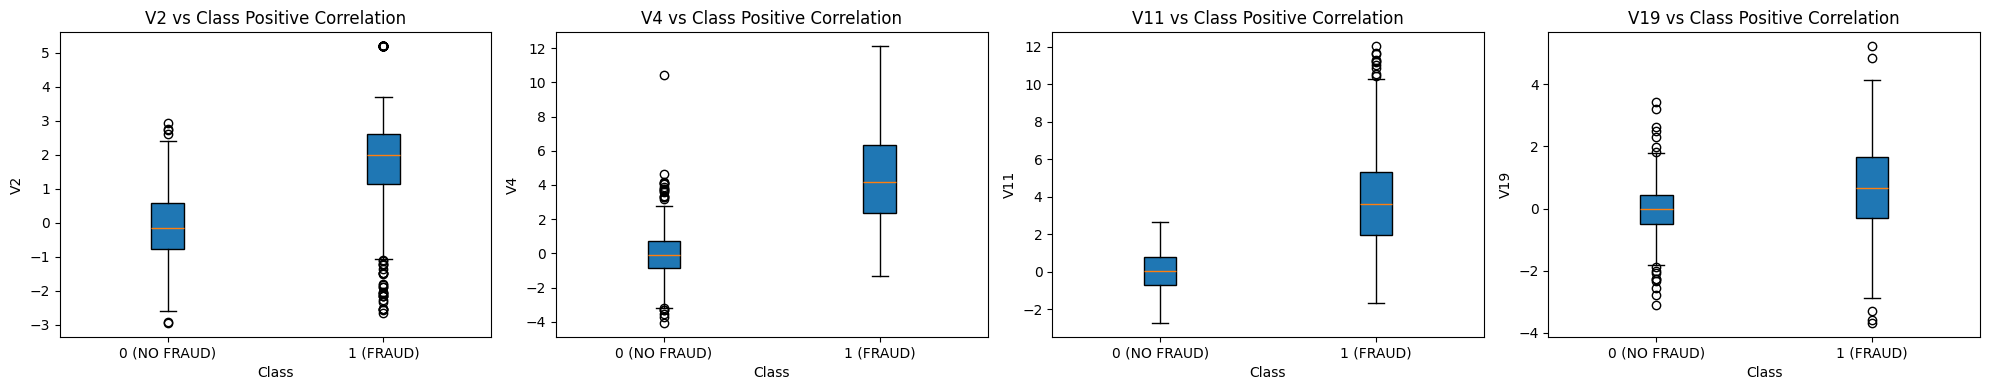

In [11]:
# Plot boxplots for features negatively correlated with fraud
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))
features = ['V10', 'V12', 'V14', 'V17']
titles = [
    'V10 vs Class Negative Correlation',
    'V12 vs Class Negative Correlation',
    'V14 vs Class Negative Correlation',
    'V17 vs Class Negative Correlation'
]

for i, feature in enumerate(features):
    ax = axes[i]
    # Separate feature values by class label
    class_0 = df_sample[df_sample['Class'] == 0][feature]
    class_1 = df_sample[df_sample['Class'] == 1][feature]
    
    # Boxplot showing distribution of feature for each class
    ax.boxplot([class_0, class_1], tick_labels=['0 (NO FRAUD)', '1 (FRAUD)'], patch_artist=True)
    ax.set_title(titles[i])
    ax.set_xlabel('Class')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()


# Plot boxplots for features positively correlated with fraud
fig, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Features with positive correlation to fraud
features = ['V2', 'V4', 'V11', 'V19']
titles = [
    'V2 vs Class Positive Correlation',
    'V4 vs Class Positive Correlation',
    'V11 vs Class Positive Correlation',
    'V19 vs Class Positive Correlation'
]

for i, feature in enumerate(features):
    ax = axes[i]
    # Separate feature values by class label
    class_0 = df_sample[df_sample['Class'] == 0][feature]
    class_1 = df_sample[df_sample['Class'] == 1][feature]

    # Boxplot showing distribution of feature for each class
    ax.boxplot([class_0, class_1], tick_labels=['0 (NO FRAUD)', '1 (FRAUD)'], patch_artist=True)
    ax.set_title(titles[i])
    ax.set_xlabel('Class')
    ax.set_ylabel(feature)

plt.tight_layout()
plt.show()


Removing Outliers

In [12]:
# Function to remove outliers based on IQR method for a specific feature and class=1 (fraud)
def remove_outliers_iqr(df, feature, class_label=1):
    # Filter feature values for fraud class only
    feature_values = df.loc[df['Class'] == class_label, feature].values
    
    # Calculate 25th and 75th percentiles (Q1 and Q3)
    q25, q75 = np.percentile(feature_values, 25), np.percentile(feature_values, 75)
    iqr = q75 - q25
    
    # Define outlier cut-off thresholds
    cut_off = iqr * 1.5
    lower_bound, upper_bound = q25 - cut_off, q75 + cut_off
    
    print(f"{feature} - Q1: {q25}, Q3: {q75}")
    print(f"IQR: {iqr}")
    print(f"Cut-off: {cut_off}")
    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")
    
    # Identify outliers outside the bounds
    outliers = [x for x in feature_values if x < lower_bound or x > upper_bound]
    print(f"{feature} Outliers for Fraud Cases: {len(outliers)}")
    print(f"Outlier values: {outliers}")
    
    # Drop outliers from the dataframe
    df_cleaned = df.drop(df[(df[feature] > upper_bound) | (df[feature] < lower_bound)].index)
    
    print(f"Number of instances after removing {feature} outliers: {len(df_cleaned)}")
    print('-'*60)
    
    return df_cleaned

# Remove outliers sequentially for V14, V12, and V10 features
df_sample = remove_outliers_iqr(df_sample, 'V14')
df_sample = remove_outliers_iqr(df_sample, 'V12')
df_sample = remove_outliers_iqr(df_sample, 'V10')


V14 - Q1: -9.692722964972386, Q3: -4.282820849486865
IQR: 5.409902115485521
Cut-off: 8.114853173228282
Lower bound: -17.807576138200666
Upper bound: 3.8320323237414167
V14 Outliers for Fraud Cases: 4
Outlier values: [np.float64(-19.2143254902614), np.float64(-18.4937733551053), np.float64(-18.0499976898594), np.float64(-18.8220867423816)]
Number of instances after removing V14 outliers: 980
------------------------------------------------------------
V12 - Q1: -8.67303320439115, Q3: -2.893030568676315
IQR: 5.780002635714835
Cut-off: 8.670003953572252
Lower bound: -17.3430371579634
Upper bound: 5.776973384895937
V12 Outliers for Fraud Cases: 4
Outlier values: [np.float64(-18.5536970096458), np.float64(-18.0475965708216), np.float64(-18.6837146333443), np.float64(-18.4311310279993)]
Number of instances after removing V12 outliers: 976
------------------------------------------------------------
V10 - Q1: -7.466658535821847, Q3: -2.5118611381562523
IQR: 4.954797397665595
Cut-off: 7.432196

Applying dimensionality reduction techniques

T-SNE took 4.6 s
PCA took 0.0034 s
Truncated SVD took 0.0046 s


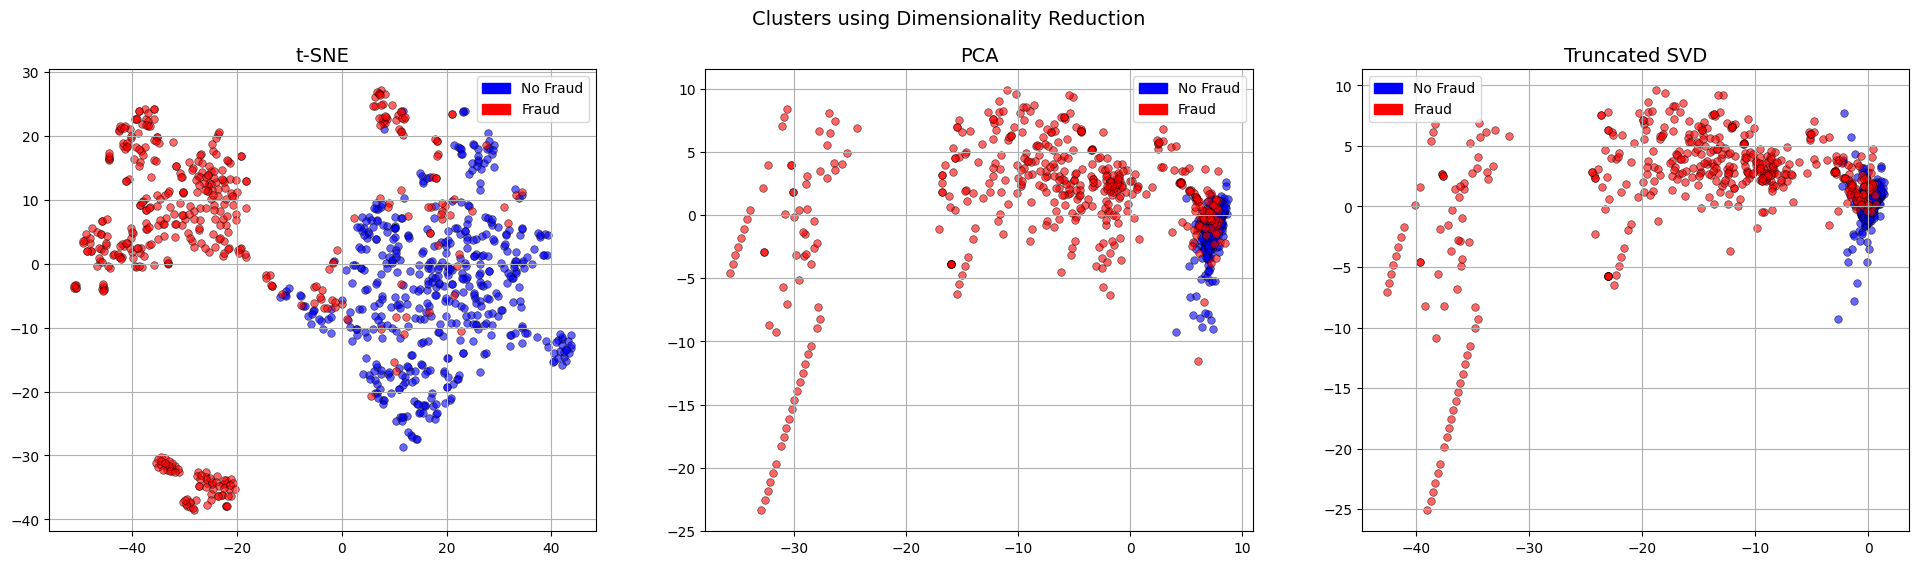

In [13]:
# Separate features and target
X = df_sample.drop('Class', axis=1)
y = df_sample['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=seed).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=seed).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=seed).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

# Plotting results side-by-side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
fig.suptitle('Clusters using Dimensionality Reduction', fontsize=14)

# Define legend patches for classes
blue_patch = mpatches.Patch(color='blue', label='No Fraud')
red_patch = mpatches.Patch(color='red', label='Fraud')

# Helper function to plot scatter with class colors
def plot_scatter(ax, data_2d, labels, title):
    # Plot non-fraud points
    ax.scatter(
        data_2d[labels == 0, 0], data_2d[labels == 0, 1], 
        c='blue', label='No Fraud', alpha=0.6, edgecolor='k', linewidth=0.5, s=30
    )
    # Plot fraud points
    ax.scatter(
        data_2d[labels == 1, 0], data_2d[labels == 1, 1], 
        c='red', label='Fraud', alpha=0.6, edgecolor='k', linewidth=0.5, s=30
    )
    ax.set_title(title, fontsize=14)
    ax.grid(True)
    ax.legend(handles=[blue_patch, red_patch])

# Plot each reduced dataset
plot_scatter(ax1, X_reduced_tsne, y.values, 't-SNE')
plot_scatter(ax2, X_reduced_pca, y.values, 'PCA')
plot_scatter(ax3, X_reduced_svd, y.values, 'Truncated SVD')

plt.show()

### 2. Applying KNN

KNN doesn't require training, because it is a "lazy learner" but, because I wanted to create a code that could be generalized and used for other algorthms to compare performance, I divided the sample in train and test 

In [14]:
# Split the dataset into training and test sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Convert the data from pandas dataframe/Series to NumPy arrays 
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Define a dictionary of classifiers to test 
classifiers = {
    "KNearest": KNeighborsClassifier(),
}

# Train each classifier and evaluate its performance using 5-fold cross-validation
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

# Define hyperparameter grid for K-Nearest Neighbors (number of neighbors and search algorithm)
knears_params = {"n_neighbors": list(range(2,5,1)), 
                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Perform grid search with cross-validation to find the best KNN configuration
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

# Extract the best model found by GridSearchCV
knears_neighbors = grid_knears.best_estimator_

# Evaluate the optimized model using 5-fold cross-validation accuracy
knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

# Generate cross-validated predictions for ROC AUC evaluation
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
print('KNears Neighbors ROC AUC Score: ', round(roc_auc_score(y_train, knears_pred) * 100, 2).astype(str) + '%')

Classifiers:  KNeighborsClassifier Has a training score of 92.0 % accuracy score
Knears Neighbors Cross Validation Score 93.21%
KNears Neighbors ROC AUC Score:  93.02%


Confusion Matrix
- Upper Left Square: The amount of correctly classified by our model of no fraud transactions.

- Upper Right Square: The amount of incorrectly classified transactions as fraud cases, but the actual label is no fraud .

- Lower Left Square: The amount of incorrectly classified transactions as no fraud cases, but the actual label is fraud .

- Lower Right Square: The amount of correctly classified by our model of fraud transactions.

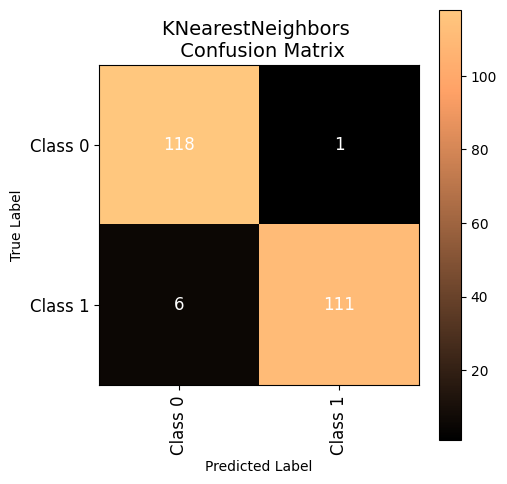

In [15]:
# Generate predictions and confusion matrix
y_pred_knear = knears_neighbors.predict(X_test)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)

fig, ax = plt.subplots(figsize=(5, 5))

# Plot the confusion matrix using imshow
cax = ax.imshow(kneighbors_cf, interpolation='nearest', cmap=plt.cm.copper)
fig.colorbar(cax)

# Set title
ax.set_title("KNearestNeighbors \n Confusion Matrix", fontsize=14)

# Set tick labels 
class_names = ['Class 0', 'Class 1']
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=12, rotation=90)
ax.set_yticklabels(class_names, fontsize=12)

# Annotate each cell with its value
for i in range(kneighbors_cf.shape[0]):
    for j in range(kneighbors_cf.shape[1]):
        ax.text(j, i, format(kneighbors_cf[i, j], 'd'),
                ha="center", va="center", color="white", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [16]:
# Print the title
print('KNN:')

# Display a detailed classification report (precision, recall, F1-score, support) for the test set predictions
print(classification_report(y_test, y_pred_knear))

KNN:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       119
           1       0.99      0.95      0.97       117

    accuracy                           0.97       236
   macro avg       0.97      0.97      0.97       236
weighted avg       0.97      0.97      0.97       236



ROC AUC

ROC AUC Score: 0.9701572936867054


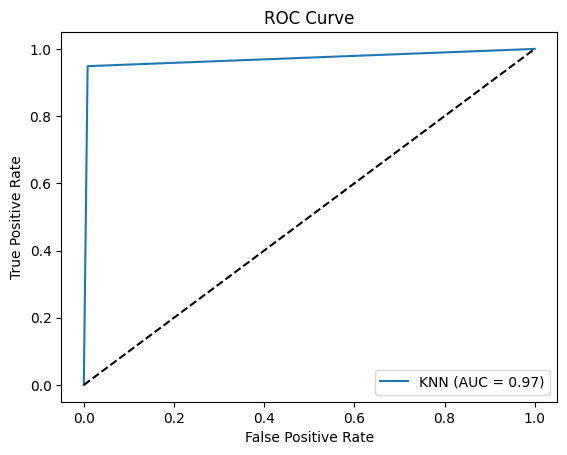

In [18]:
# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_knear)

# Print ROC AUC
print('ROC AUC Score:', roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_knear)

plt.figure()
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
